以下の人を想定。
- 納税者本人: 障害なし、勤労学生ではない
- 配偶者: なし
- 扶養家族: なし
- 被保険者種別: 第1号被保険者
- 事業収入:
    - 営業売上: 0〜1,500,000円（10万区切りで計算）
    - 売上原価: 0円
    - 経費: 0円
- 申告年: 令和6年をベースに定額減税をなしにした設定

国民健康保険
- 加入地域: 東京都杉並区
- 介護分: 負担あり（40歳以上）

国民年金保険
- 199,490円（口座振替で1年前納）

消費税
- 課税制度: 簡易課税
- みなし仕入率: 50%

住民税
- 合計所得金額が一定金額（45万円）以下の場合は免除

In [ ]:
import os
import sys

import pandas as pd

pd.set_option("display.max_rows", None)

sys.path.append(os.path.join(os.getcwd(), '..', 'lib'))

from const.所得税_基礎控除_R2 import 所得税_基礎控除_R2
from const.所得税_税率_H27 import 所得税_税率_H27
from const.給与所得控除_R2 import 給与所得控除_R2
from const.国民健康保険_R6 import 国民健康保険_R6
from const.住民税_基礎控除_R3 import 住民税_基礎控除_R3
from const.住民税_税率一覧_R7 import 住民税_税率一覧_R7
from context import get_context, open_clone_context

from 所得.事業所得 import 損益計算書
from 所得税及び復興特別所得税の申告内容確認表_第一表_第一表 import 所得税及び復興特別所得税の申告内容確認表_第一表, 所得金額等
from 国民健康保険 import 国民健康保険
from 住民税 import 住民税
from ふるさと納税 import ふるさと納税上限額
from 納税者 import 納税者

from 消費税及び地方消費税.共通.課税売上高計算表 import 課税売上高計算表
from 消費税及び地方消費税.簡易課税.控除対象仕入税額等の計算表_1種類の事業の専業者 import 控除対象仕入税額等の計算表_1種類の事業の専業者
from 消費税及び地方消費税.簡易課税.税率別消費税額計算表 import 税率別消費税額計算表, みなし仕入率_サービス業等
from 消費税及び地方消費税.共通.消費税及び地方消費税の申告書_第二表 import 消費税及び地方消費税の申告書_第二表
from 消費税及び地方消費税.簡易課税.消費税及び地方消費税の申告書_第一表 import 消費税及び地方消費税の申告書_第一表

In [2]:
"""
設定項目 年に対する定数
"""
# 2024年(R6)
context = get_context()
context.給与所得控除 = 給与所得控除_R2()
context.所得税_基礎控除 = 所得税_基礎控除_R2()
context.所得税_税率 = 所得税_税率_H27()
context.住民税_基礎控除 = 住民税_基礎控除_R3()
context.住民税_税率一覧 = 住民税_税率一覧_R7()
context.国民健康保険 = 国民健康保険_R6()

In [3]:
"""
設定項目 納税者情報
"""
# 納税者
# 年齢によって国民健康保険の介護分の有無が変わる
# 国民健康保険の加入地域によって保険料率が変わる
x納税者 = 納税者()
x納税者.納税者本人.年齢 = 40
x納税者.国民健康保険_加入地域 = '東京都杉並区'

# 業種によって消費税が変わる
xみなし仕入率 = みなし仕入率_サービス業等

In [4]:
def 年収内訳(x納税者: 納税者, 収入金額: int) -> pd.Series:
    # 所得
    x損益計算書 = 損益計算書(収入金額)
    x所得金額等 = 所得金額等(事業_営業等=x損益計算書)

    # 国民健康保険、国民年金保険
    x国民健康保険 = 国民健康保険(x所得金額等, x納税者)
    # 国民健康保険_dic = x国民健康保険.区分別保険料
    国民健康保険_i = x国民健康保険.保険料
    国民年金保険_i = 199_490
    x納税者.社会保険料 = 国民健康保険_i + 国民年金保険_i

    # 所得税
    x所得税及び復興特別所得税の申告内容確認表_第一表 = 所得税及び復興特別所得税の申告内容確認表_第一表(所得金額等=x所得金額等, 納税者=x納税者)
    所得税_i = x所得税及び復興特別所得税の申告内容確認表_第一表.所得税_税額控除.申告納税額

    # 消費税
    x課税売上高計算表 = 課税売上高計算表()
    x課税売上高計算表.うち標準税率7_8per適用分.事業所得に係る課税売上高_営業等課税売上高 = x損益計算書.売上金額
    x控除対象仕入税額等の計算表 = 控除対象仕入税額等の計算表_1種類の事業の専業者(みなし仕入率=xみなし仕入率)
    x税率別消費税額計算表 = 税率別消費税額計算表(課税売上高計算表=x課税売上高計算表, 控除対象仕入税額等の計算表=x控除対象仕入税額等の計算表)
    x消費税及び地方消費税の申告書_第二表 = 消費税及び地方消費税の申告書_第二表(税率別消費税額計算表=x税率別消費税額計算表)
    x消費税及び地方消費税の申告書_第一表 = 消費税及び地方消費税の申告書_第一表(消費税及び地方消費税の申告書_第二表=x消費税及び地方消費税の申告書_第二表)
    消費税_i = x消費税及び地方消費税の申告書_第一表.消費税及び地方消費税の合計税額

    # 住民税
    # 前年中の合計所得金額が一定金額以下の場合は免除
    # 扶養家族（同一生計対象配偶者または扶養親族）がいない場合は45万円
    if x所得金額等.合計所得金額>450_000:
        x住民税 = 住民税(所得税_所得控除=x所得税及び復興特別所得税の申告内容確認表_第一表.所得税_所得控除, 納税者=x納税者)
        住民税_i = x住民税.年税額
    else:
        住民税_i = 0

    # 手取り
    手取り_i = 収入金額 - x納税者.社会保険料 - 所得税_i - 消費税_i - 住民税_i

    return pd.Series({
        '年収': 収入金額,
        '国民健康保険': 国民健康保険_i,
        # **国民健康保険_dic,
        '国民年金保険': 国民年金保険_i,
        '国民年金保険内訳': x国民健康保険.to_dataframe(),
        '所得税': 所得税_i,
        '消費税': 消費税_i,
        '住民税': 住民税_i,
        '手取り': 手取り_i,
        'ふるさと納税上限額': ふるさと納税上限額(x所得金額等, x納税者),
    })

In [5]:
def 年収グラフデータ(年収range: range) -> pd.DataFrame:
    年収内訳df = pd.DataFrame()
    for i in 年収range:
        ser = 年収内訳(x納税者, i)
        年収内訳df = pd.concat([年収内訳df, pd.DataFrame([ser])], ignore_index=True)
    return 年収内訳df

In [6]:
"""
国民民主党案
"""
from meta.住民税 import I住民税_基礎控除
from meta.所得税 import I所得税_基礎控除
from utils import get_range_dict_value, intfloor

class 所得税_基礎控除_国民民主党案(I所得税_基礎控除):
    __所得税_基礎控除の定義: dict[range,int] = {
        # 2,400万円以下
        range(-sys.maxsize,  24_000_001): 1_230_000,
        # 2,400万円超2,450万円以下
        range(  24_000_001,  24_500_001): 1_070_000,
        # 2,450万円超2,500万円以下
        range(  24_500_001,  25_000_001): 910_000,
        # 2,500万円超
        range(  25_000_001, sys.maxsize): 750_000,
    }

    def 所得税_基礎控除(self, 所得金額等_合計: int) -> int:
        return get_range_dict_value(self.__所得税_基礎控除の定義, 所得金額等_合計)

class 住民税_基礎控除_国民民主党案(I住民税_基礎控除):
    __住民税_基礎控除の定義: dict[range,int] = {
        # 2,400万円以下
        range(-sys.maxsize,  24_000_001): 1_180_000,
        # 2,400万円超2,450万円以下
        range(  24_000_001,  24_500_001): 1_040_000,
        # 2,450万円超2,500万円以下
        range(  24_500_001,  25_000_001): 900_000,
        # 2,500万円超
        range(  25_000_001, sys.maxsize): 750_000,
    }

    def 住民税_基礎控除(self, 合計所得金額: int) -> int:
        return get_range_dict_value(self.__住民税_基礎控除の定義, 合計所得金額)

In [7]:
"""
自民党案
"""
from meta.所得税 import I所得税_基礎控除
from meta.給与所得控除 import I給与所得控除, 給与所得控除後の金額Protocol
from utils import get_range_dict_value, intfloor

class 所得税_基礎控除_自民党案(I所得税_基礎控除):
    __所得税_基礎控除の定義: dict[range,int] = {
        # 2,400万円以下
        range(-sys.maxsize,  24_000_001): 580_000,
        # 2,400万円超2,450万円以下
        range(  24_000_001,  24_500_001): 420_000,
        # 2,450万円超2,500万円以下
        range(  24_500_001,  25_000_001): 260_000,
        # 2,500万円超
        range(  25_000_001, sys.maxsize): 100_000,
    }

    def 所得税_基礎控除(self, 所得金額等_合計: int) -> int:
        return get_range_dict_value(self.__所得税_基礎控除の定義, 所得金額等_合計)


class 給与所得控除_自民党案(I給与所得控除):
    __給与所得控除の定義: dict[range,給与所得控除後の金額Protocol] = {
        # ～650,999円
        range(-sys.maxsize,     651_000): lambda a: 0,
        # 651,000円～1,899,999円
        range(     651_000,   1_900_000): lambda a: a - 650_000,
        # 1,900,000円～3,599,999円
        range(   1_900_000,   3_600_000): lambda a: round(intfloor(a/4, 3) * 2.8 - 80_000),
        # 3,600,000円～6,599,999円
        range(   3_600_000,   6_600_000): lambda a: round(intfloor(a/4, 3) * 3.2 - 440_000),
        # 6,600,000円～8,499,999円
        range(   6_600_000,   8_500_000): lambda a: round(a * 0.9 - 1_100_000),
        # 8,500,000円～
        range(   8_500_000, sys.maxsize): lambda a: a - 1_950_000,
    }

    def 給与所得控除後の金額の式(self, 給与等の収入金額: int) -> 給与所得控除後の金額Protocol:
        return get_range_dict_value(self.__給与所得控除の定義, 給与等の収入金額)

In [8]:
年収range = range(0, 15_000_001, 100_000)

# 現行
現行_年収内訳df = 年収グラフデータ(年収range)

# 国民民主党案
with open_clone_context() as context:
    context.所得税_基礎控除 = 所得税_基礎控除_国民民主党案()
    context.住民税_基礎控除 = 住民税_基礎控除_国民民主党案()
    国民民主党案_年収内訳df = 年収グラフデータ(年収range)

# 自民党案
with open_clone_context() as context:
    context.所得税_基礎控除 = 所得税_基礎控除_自民党案()
    context.給与所得控除 = 給与所得控除_自民党案()
    自民党案_年収内訳df = 年収グラフデータ(年収range)

In [9]:
df = pd.DataFrame()
df['年収'] = 現行_年収内訳df['年収']
df['現行税額'] = 現行_年収内訳df['年収'] - 現行_年収内訳df['手取り']

df['自民党案_減税額'] = 自民党案_年収内訳df['手取り'] - 現行_年収内訳df['手取り']
df['国民民主党案_減税額'] = 国民民主党案_年収内訳df['手取り'] - 現行_年収内訳df['手取り']

df['自民党案_税額'] = df['現行税額'] - df['自民党案_減税額']
df['国民民主党案_税額'] = df['現行税額'] - df['国民民主党案_減税額']

df['自民党案_減税率'] = df['自民党案_減税額'] / df['現行税額']
df['国民民主党案_減税率'] = df['国民民主党案_減税額'] / df['現行税額']

df[['年収', '自民党案_減税額', '国民民主党案_減税額']][df['年収'].isin([2_000_000, 3_000_000, 5_000_000, 6_000_000, 8_000_000, 10_000_000])]

,年収,自民党案_減税額,国民民主党案_減税額
20,2000000,10100,179875
30,3000000,10100,200475
50,5000000,10200,233475
60,6000000,20400,299375
80,8000000,20400,299475
100,10000000,23500,250590


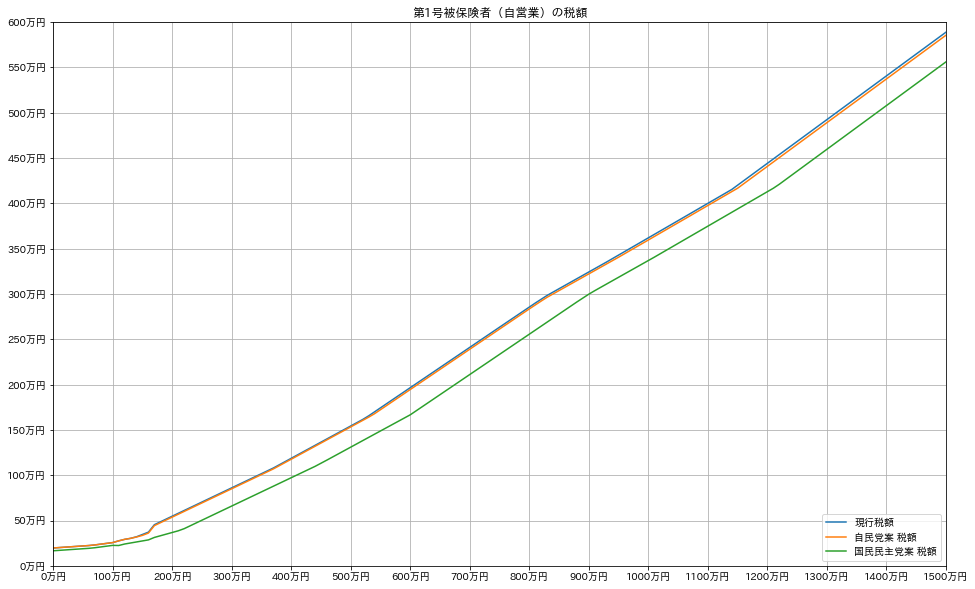

In [10]:
import matplotlib.pyplot as plt

xticks_indexes = range(年収range.start, 年収range.stop, 1_000_000)
xticks_labels = list(map(lambda x: f'{round(x/10_000)}万円', xticks_indexes))

yticks_indexes = range(年収range.start, 年収range.stop, 500_000)
yticks_labels = list(map(lambda x: f'{round(x/10_000)}万円', yticks_indexes))

plt.figure(figsize=(16, 10), facecolor='#ffffff')
plt.title('第1号被保険者（自営業）の税額')
plt.plot(df['年収'], df['現行税額'], label='現行税額')
plt.plot(df['年収'], df['自民党案_税額'], label='自民党案 税額')
plt.plot(df['年収'], df['国民民主党案_税額'], label='国民民主党案 税額')
plt.xticks(xticks_indexes, xticks_labels)
plt.yticks(yticks_indexes, yticks_labels)
plt.xlim(年収range.start, 年収range.stop)
plt.ylim(0, 6_000_000)
plt.legend(loc='lower right')
plt.grid()
plt.show()

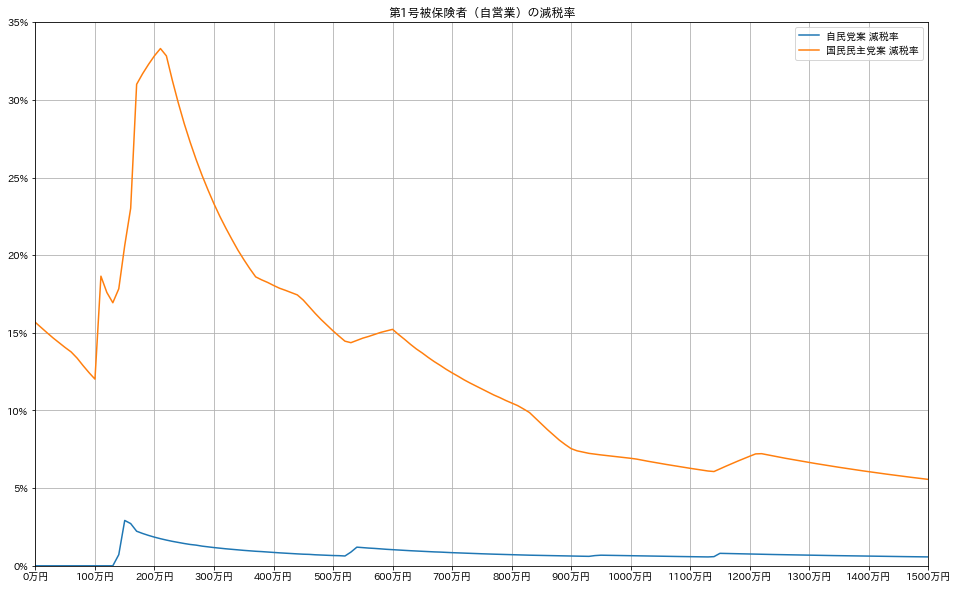

In [11]:
import matplotlib.pyplot as plt

xticks_indexes = range(年収range.start, 年収range.stop, 1_000_000)
xticks_labels = list(map(lambda x: f'{round(x/10_000)}万円', xticks_indexes))

yticks_indexes = range(0, 101, 5)
yticks_labels = list(map(lambda x: f'{x}%', yticks_indexes))

plt.figure(figsize=(16, 10), facecolor='#ffffff')
plt.title('第1号被保険者（自営業）の減税率')
plt.plot(df['年収'], df['自民党案_減税率']*100, label='自民党案 減税率')
plt.plot(df['年収'], df['国民民主党案_減税率']*100, label='国民民主党案 減税率')
plt.xticks(xticks_indexes, xticks_labels)
plt.yticks(yticks_indexes, yticks_labels)
plt.xlim(年収range.start, 年収range.stop)
plt.ylim(0, 35)
plt.legend(loc='upper right')
plt.grid()
plt.show()